In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.metrics as mtcs
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
import sklearn.ensemble as ens
import sklearn.feature_selection as fs
from sklearn.pipeline import Pipeline
from sklearn.linear_model.base import BaseEstimator


from tqdm import tqdm
from statsmodels.stats.weightstats import ztest
from xgboost import XGBClassifier

%matplotlib inline

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data uploading&preview

In [2]:
data = _data_ = pd.read_csv('./data/train.csv')

data

,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-1515,feature-1516,feature-1517,feature-1518,feature-1519,feature-1520,feature-1521,feature-1522,feature-1523,y
0,37.977273,6.758452,3.636364,10.792929,160.801682,151.109783,1.791689,6.818675,8.138413,8.270161,...,5.658393,4.151040,4.540632,4.953183,5.351562,5.311048,5.560922,5.643015,5.715999,0.0
1,19.408163,5.933978,2.816327,5.877551,162.949911,76.153796,1.381401,6.002651,5.080499,7.514421,...,4.830811,3.817712,4.123094,4.426343,4.823804,4.652173,4.795274,4.860781,5.001426,0.0
2,40.265306,7.425645,3.734694,13.160998,172.099640,161.790879,1.603976,7.410120,10.114794,8.805738,...,6.397659,4.223177,4.685597,5.116870,5.333926,5.504569,5.797956,6.009581,6.200889,0.0
3,43.976744,7.648293,3.837209,14.392765,168.885456,175.277251,1.622298,7.629033,12.180817,9.070719,...,5.879135,4.280132,4.563045,5.007714,5.159773,5.393628,5.640132,5.472271,5.741399,0.0
4,24.320988,6.534011,3.567901,8.913580,163.076959,96.019681,1.380679,6.566695,4.417010,8.058783,...,8.148663,4.624973,5.173321,5.720312,6.259342,6.626469,7.062406,7.472998,7.829842,0.0
5,20.924051,6.134299,3.037975,6.506329,165.707039,82.761541,1.381957,6.187547,4.684599,7.660347,...,6.087556,4.430817,4.820282,5.183187,5.595176,5.489454,5.604998,5.847522,5.987080,0.0
6,34.150000,6.740695,3.733333,10.214815,164.252922,135.639059,1.620887,6.781702,8.631090,8.248393,...,6.198225,4.471639,4.801970,5.237107,5.493833,5.573816,5.764799,5.865760,5.998937,0.0
7,23.833333,6.395508,3.141026,8.717949,163.221967,94.106131,1.435936,6.443753,5.834402,7.904135,...,6.582328,4.600158,5.032071,5.499726,5.978728,5.995208,6.179952,6.364051,6.481290,0.0
8,32.380952,6.152543,2.857143,6.402116,164.380868,128.391104,1.687697,6.232890,4.476844,7.736528,...,0.000000,3.449988,3.865979,4.506730,4.765906,4.965028,3.840795,3.595598,0.000000,0.0
9,45.228571,6.608449,3.714286,9.180952,159.167580,180.141749,1.981354,6.690537,8.428546,8.221041,...,5.214936,3.828641,4.234107,4.682131,4.890349,5.192957,5.342334,5.402677,5.303305,0.0


[ 0.  1.]


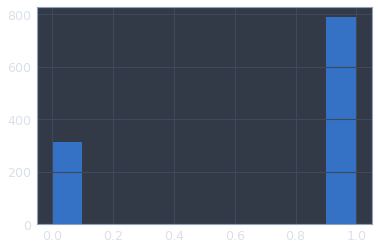

In [3]:
print(data.y.unique())
plt.hist(data.y);

In [5]:
print(data.isnull().sum().sum())

num_1 = data[data.y == 1].shape[0] 
num_0 = data[data.y == 0].shape[0]

print(num_1, num_0, num_1 / (num_0 + num_1))

0
790 315 0.7149321266968326


In [122]:
data = pp_pipeline(_data_)

(train_X, train_y,
 test_X, test_y,
 validate_X, validate_y) = split_data(data)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Common functions

In [4]:
def weight_init(name, shape):
    return tf.get_variable(name, initializer=tf.random_normal(shape=shape,
                                                              stddev=0.1))
def bias_init(name, shape):
    return tf.get_variable(name, initializer=tf.constant(0.1, shape=shape))

def elastic_net(x, l1, l2):
    return l1 * ( (1-l2) / 2 * tf.norm(x, 2) ** 2 + 
                   l2 * tf.norm(x, 1))

def batch_data(*matrxs, batch_size):
    for batch_i in range(matrxs[0].shape[0] // batch_size):
        yield tuple(x.iloc[batch_i * batch_size : (batch_i + 1) * batch_size] 
                     for x in matrxs)
        
def split_data(data, train_size=0.5, test_size=0.25, validate_size=0.25):
    train_data, test_val_data = ms.train_test_split(data, train_size=train_size)
    test_data, val_data = ms.train_test_split(test_val_data,
                                              train_size=test_size / (test_size+validate_size))
    
    train_X, train_y = train_data.drop('y', axis=1), train_data[['y']]
    test_X, test_y = test_data.drop('y', axis=1), test_data[['y']]
    validate_X, validate_y = val_data.drop('y', axis=1), val_data[['y']]
    
    return (train_X, train_y, test_X, test_y, validate_X, validate_y)

def pp_pipeline(data):
    scaler = pp.StandardScaler()
    
    data_pp = scaler.fit_transform(data)
    
    data_pp = pd.DataFrame(data_pp,
                        index=data.index,
                        columns=data.columns)
    
    #restore target
    data_pp.y = data.y
    
    return data_pp

# Feature selection

## DFS

In [106]:
class DFS(BaseEstimator):
    def __init__(self, layers_sizes=[128, 64, 2], batch_size=32, lambda1=1e-3, lambda2=1.,
                 alpha1=1e-3, alpha2=0., num_epochs=10, verbose=0, N=None):
        self.layers_sizes = layers_sizes
        self.num_layers = len(layers_sizes)
        self.batch_size = batch_size
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_epochs = num_epochs
        self.verbose = verbose
        self.N = N
        
        
    def fit(self, X, y, test_data=None):
        self._build_graph_(X.shape[1])
        self.features = X.columns #Persisting for `select_most_important_ftrs`
        self.sess = tf.Session()
        
        self.sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(self.num_epochs):
            X_cur = X.sample(frac=1, random_state=epoch_i)
            y_cur = y.sample(frac=1, random_state=epoch_i)
            epoch_loss = 0
            for batch_X, batch_y in batch_data(X_cur, y_cur, 
                                               batch_size=self.batch_size):
                train_loss, _ = self.sess.run([self.total_loss, self.train_step],
                                               feed_dict = {self.x: batch_X,
                                                            self.y: batch_y})
                epoch_loss += train_loss
            epoch_loss /= X.shape[0] // self.batch_size
            
            train_predict = self.predict(X_cur)
            train_accuracy = mtcs.accuracy_score(y_cur, train_predict)
            if self.verbose:
                if test_data is not None:
                    test_X, test_y = test_data
                    test_predict = self.predict(test_X)
                    test_accuracy = mtcs.accuracy_score(test_y, test_predict)
                    print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}."
                          f"Train accuracy: {train_accuracy}. Test accuracy: {test_accuracy}.")
                else:
                    print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}. "
                          f"Train accuracy: {train_accuracy}.")
                
        return self
       
    
    def predict_proba(self, X):
        predictions_proba = self.sess.run(self.predictions, feed_dict={self.x: X})
        
        return predictions_proba
    
    
    def predict(self, X):
        predictions_proba = self.predict_proba(X)
        
        return list(map(np.argmax, predictions_proba))
    
    
    def get_features_weights(self):
        weights = self.sess.run(self.features_weights)
        
        return weights
    
    
    def select_most_important_ftrs(self, N):
        weights = self.get_features_weights()
        feature_weight = sorted(zip(weights, self.features), 
                                key=lambda x: abs(x[0]))
        
        return map(lambda x: x[1], feature_weight[-N:])
    
    
    def transform(self, X, N=None):
        if N:
            features = list(self.select_most_important_ftrs(N))
        else:
            features = list(self.select_most_important_ftrs(self.N))
        
        return X[features]
    
     
    def _build_graph_(self, num_features):
        tf.reset_default_graph()
        
        ###Placeholders 
        x = tf.placeholder(tf.float32, [None, num_features], 'x_ph')
        y = tf.placeholder(tf.int32, [None], 'y_ph')
        
        ###Weights initialization
        w = tf.get_variable("dfs_features_weight", 
                            initializer = tf.constant(1., shape=[num_features]))
        self.layers_sizes = [num_features] + self.layers_sizes
        W, b = [], []
        for layer_i in range(self.num_layers):
            W.append(weight_init(f"layer_{layer_i}_weights",
                                 shape=[self.layers_sizes[layer_i],
                                        self.layers_sizes[layer_i+1]]))
            b.append(bias_init(f"layer_{layer_i}_bias",
                               shape=[self.layers_sizes[layer_i+1]]))
        
        ###Input transformations
        logits = x * w #feature selection
        for layer_i in range(self.num_layers):
            if layer_i != self.num_layers - 1:
                logits = tf.nn.tanh(tf.matmul(logits, W[layer_i]) + b[layer_i])
            else:
                logits = tf.matmul(logits, W[layer_i]) + b[layer_i]
        predictions = tf.nn.softmax(logits)
            
        ###Loss calculation
        logloss = tf.reduce_sum(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, 
                                                                       logits=logits))
        w_loss = elastic_net(w, self.lambda1, self.lambda2)
        W_loss = tf.reduce_sum([elastic_net(W_i, self.alpha1, self.alpha2) for W_i in W])
        
        total_loss = tf.reduce_sum(logloss + w_loss + W_loss)
        
        ###Optimizer
        train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)
        
        self.x = x
        self.y = y
        self.predictions = predictions
        self.total_loss = total_loss
        self.train_step = train_step
        self.features_weights = w
        

In [171]:
dfs = DFS([128, 64, 2])

dfs.fit(train_X, train_y['y'], num_epochs=200, test_data=(test_X, test_y))

==> Epoch: 0. Train loss: 20.95456891901353.Train accuracy: 0.8351449275362319. Test accuracy: 0.7536231884057971.
==> Epoch: 1. Train loss: 12.762776206521426.Train accuracy: 0.9456521739130435. Test accuracy: 0.822463768115942.
==> Epoch: 2. Train loss: 9.08758960050695.Train accuracy: 0.9637681159420289. Test accuracy: 0.8442028985507246.
==> Epoch: 3. Train loss: 6.838204552145565.Train accuracy: 0.9710144927536232. Test accuracy: 0.8188405797101449.
==> Epoch: 4. Train loss: 5.353214488309972.Train accuracy: 0.9927536231884058. Test accuracy: 0.8297101449275363.
==> Epoch: 5. Train loss: 4.301174023572137.Train accuracy: 0.9981884057971014. Test accuracy: 0.8442028985507246.
==> Epoch: 6. Train loss: 3.583045917398789.Train accuracy: 0.9981884057971014. Test accuracy: 0.8260869565217391.
==> Epoch: 7. Train loss: 3.1851401188794304.Train accuracy: 1.0. Test accuracy: 0.8297101449275363.
==> Epoch: 8. Train loss: 2.95365205933066.Train accuracy: 1.0. Test accuracy: 0.81884057971014

KeyboardInterrupt: 

(array([ 149.,   14.,   16.,   36.,  118.,  386.,  499.,  271.,   30.,    5.]),
 array([-0.01604488,  0.08977009,  0.19558506,  0.30140003,  0.40721501,
         0.51302998,  0.61884495,  0.72465992,  0.8304749 ,  0.93628987,
         1.04210484]),
 <a list of 10 Patch objects>)

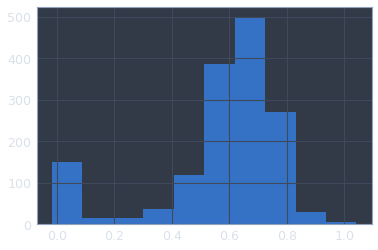

In [56]:
plt.hist(dfs.get_features_weights())

## Lasso

In [141]:
class LassoFS(BaseEstimator):
    def __init__(self, N=None):
        self.N = N
        self.est = lm.LogisticRegression(penalty='l1')
    
    
    def fit(self, X, y):
        self.est.fit(train_X, train_y)
        self.features = train_X.columns
        
        return self
    
    
    def transform(self, X, N=None):
        if N:
            features = list(self.select_most_important_ftrs(N))
        else:
            features = list(self.select_most_important_ftrs(self.N))
        
        return X[features]

    
    def predict(self, X):
        return self.est.predict(X)
    
    
    @property
    def coef_(self):
        return self.est.coef_


    def select_most_important_ftrs(self, N):
        feature_weight = sorted(zip(self.est.coef_[0], self.features),
                                key=lambda x: abs(x[0]))

        return list(map(lambda x: x[1], feature_weight[-N:]))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.851449275362


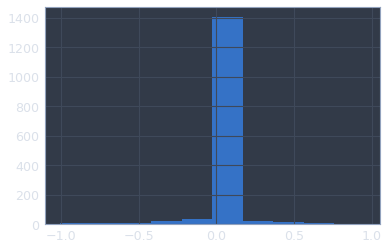

In [131]:
est = LassoFS();
est.fit(train_X, train_y.y);
print(mtcs.accuracy_score(test_y, est.predict(test_X)))
plt.hist(est.coef_[0]);

## Random forest

In [133]:
class RandomForestFS(BaseEstimator):
    def __init__(self, N=None):
        self.N = N
        self.est = ens.RandomForestClassifier()
        
        
    def fit(self, X, y):
        self.est.fit(X, y)
        self.features = X.columns
        
        return self
    
    
    def transform(self, X, N=None):
        if N:
            features = self.select_most_important_ftrs(N)
        else:
            features = self.select_most_important_ftrs(self.N)
            
        return X[features]

    
    def predict(self, X):
        return self.est.predict(X)
    
    
    @property
    def feature_importances_(self):
        return self.est.feature_importances_
    
    
    def select_most_important_ftrs(self, N):
        feature_weight = sorted( zip(self.est.feature_importances_,
                                     self.features),
                                 key=lambda x: x[0])
        return list(map(lambda x: x[1], feature_weight[-N:]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.836956521739


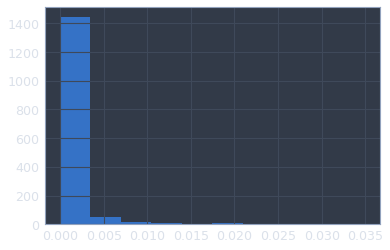

In [135]:
est = RandomForestFS();
est.fit(train_X, train_y);
print(mtcs.accuracy_score(test_y, est.predict(test_X)))
plt.hist(est.feature_importances_);

# Classification models

## Random Forest

In [127]:
class RandomForestFS(BaseEstimator):
    def __init__(self)

est = ens.RandomForestClassifier()

train_X_dfs = dfs.transform(train_X, 500)
test_X_dfs = dfs.transform(test_X, 500)

est.fit(train_X_dfs, train_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [68]:
mtcs.accuracy_score(test_y, est.predict(test_X_dfs))

0.87681159420289856

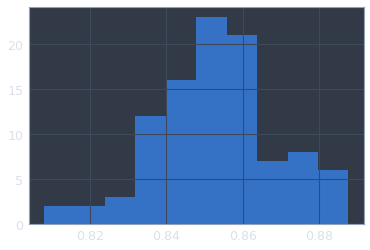

(array([  1.,   2.,   0.,   8.,  14.,  20.,  26.,  22.,   4.,   3.]),
 array([ 0.79710145,  0.80724638,  0.8173913 ,  0.82753623,  0.83768116,
         0.84782609,  0.85797101,  0.86811594,  0.87826087,  0.8884058 ,
         0.89855072]),
 <a list of 10 Patch objects>)

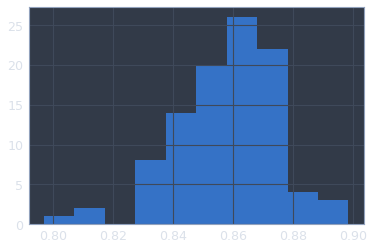

In [94]:
plt.hist(acc_p)
plt.show()
plt.hist(acc_dfs)

In [107]:
ztest(acc_p, acc_dfs)

(-1.8637867739884362, 0.062351653820433672)

## Gradient Boosting

In [ ]:
def select_most_important_ftrs(est, features, N):
    feature_weight = sorted(zip(est.coef_[0], features),
                            key=lambda x: abs(x[0]))
    
    return list(map(lambda x: x[1], feature_weight[-N:]))

In [128]:
est = XGBClassifier(n_estimators=1000, n_jobs=40, silent=False)

est.fit(train_X_dfs, train_y, verbose=True)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=40, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1)

In [124]:
mtcs.accuracy_score(test_y, est.predict(test_X))

0.8876811594202898

In [125]:
est.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

# Hyperparameters optimization

In [142]:
pipeline = Pipeline([
    ('select_ftrs', LassoFS()),
    ('main', ens.RandomForestClassifier())
])

param_grid = [
    {
#      'select_ftrs__lambda1': [1e-3, 5e-3],
#      'select_ftrs__num_epochs': [10, 100]
     'select_ftrs__N': [0, 100]
#      'main__n_estimators': [10, 25, 50]
    }
]

In [143]:
grid = ms.GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid,
                       verbose=100, scoring='accuracy')
grid.fit(train_X, train_y.y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] select_ftrs__N=0 ................................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... select_ftrs__N=0, score=0.875, total=   0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[CV] select_ftrs__N=0 ................................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... select_ftrs__N=0, score=0.8260869565217391, total=   0.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[CV] select_ftrs__N=0 ................................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... select_ftrs__N=0, score=0.7989130434782609, total=   0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[CV] select_ftrs__N=100 ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... select_ftrs__N=100, score=0.8804347826086957, total=   0.2s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[CV] select_ftrs__N=100 ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... select_ftrs__N=100, score=0.8369565217391305, total=   0.2s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s
[CV] select_ftrs__N=100 ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... select_ftrs__N=100, score=0.8478260869565217, total=   0.3s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s finished


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select_ftrs', LassoFS(N=None)), ('main', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
   ..._jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'select_ftrs__N': [0, 100]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=100)

In [144]:
grid.best_score_, grid.best_params_

(0.85507246376811596, {'select_ftrs__N': 100})

In [33]:
grid.cv_results_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([ 1.59288263,  9.28491696,  1.65082256,  9.04132112]),
 'mean_score_time': array([ 0.0058229 ,  0.00650056,  0.00610256,  0.00602126]),
 'mean_test_score': array([ 0.86050725,  0.8423913 ,  0.8442029 ,  0.86050725]),
 'mean_train_score': array([ 1.,  1.,  1.,  1.]),
 'param_select_ftrs__lambda1': masked_array(data = [0.001 0.001 0.005 0.005],
              mask = [False False False False],
        fill_value = ?),
 'param_select_ftrs__num_epochs': masked_array(data = [10 100 10 100],
              mask = [False False False False],
        fill_value = ?),
 'params': [{'select_ftrs__lambda1': 0.001, 'select_ftrs__num_epochs': 10},
  {'select_ftrs__lambda1': 0.001, 'select_ftrs__num_epochs': 100},
  {'select_ftrs__lambda1': 0.005, 'select_ftrs__num_epochs': 10},
  {'select_ftrs__lambda1': 0.005, 'select_ftrs__num_epochs': 100}],
 'rank_test_score': array([1, 4, 3, 1], dtype=int32),
 'split0_test_score': array([ 0.84782609,  0.83152174,  0.81521739,  0.8423913 ]),
